In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from tqdm import tqdm
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, InceptionV3
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, Activation, MaxPooling2D,
                                     GlobalAveragePooling2D, Dense, Dropout, Add, Flatten, Layer)
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [4]:
def load_images_from_directory(directory, label):
    data = []
    labels = []
    filenames = []

    for filename in tqdm(os.listdir(directory), desc=f"Loading {directory}"):
        filepath = os.path.join(directory, filename)
        with Image.open(filepath) as img:
            img = img.convert('L')  # Convert to grayscale
            img = img.resize((256, 256))  # Resize to 256x256 pixels
            img_array = np.array(img)
            data.append(img_array)
            labels.append(label)
            filenames.append(filename)

    return np.array(data), np.array(labels), filenames

In [5]:
# Directories
yes_nosied_directory = 'C:/Users/limvi/Desktop/FYP1/BrainTumorDataset-Noised/yes'
no_noised_directory = 'C:/Users/limvi/Desktop/FYP1/BrainTumorDataset-Noised/no'

In [6]:
# Load data
yes_noised_data, yes_noised_labels, yes_noised_filenames = load_images_from_directory(yes_nosied_directory, 1)  # 1 for tumor
no_noised_data, no_noised_labels, no_noised_filenames = load_images_from_directory(no_noised_directory, 0)  # 0 for no tumor

Loading C:/Users/limvi/Desktop/FYP1/BrainTumorDataset-Noised/yes: 100%|██████████| 155/155 [00:00<00:00, 503.94it/s]
Loading C:/Users/limvi/Desktop/FYP1/BrainTumorDataset-Noised/no: 100%|██████████| 155/155 [00:00<00:00, 465.70it/s]


In [7]:
# Function to crop images based on contours
def contour_cropping(images, add_pixels_value=0, target_size=(256, 256)):
    cropped_images = []
    for img in images:
        # Ensure img is a numpy array with dtype 'uint8'
        img = img.astype(np.uint8)
        blurred = cv2.GaussianBlur(img, (5, 5), 0)
        _, thresh = cv2.threshold(blurred, 45, 255, cv2.THRESH_BINARY)
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            x, y, w, h = cv2.boundingRect(largest_contour)
            x_start = max(0, x - add_pixels_value)
            y_start = max(0, y - add_pixels_value)
            x_end = min(img.shape[1], x + w + add_pixels_value)
            y_end = min(img.shape[0], y + h + add_pixels_value)
            cropped_image = img[y_start:y_end, x_start:x_end]
        else:
            # If no contours are found, use the original image
            cropped_image = img

        # Resize cropped image to the target size
        resized_image = cv2.resize(cropped_image, target_size)
        cropped_images.append(resized_image)

    return np.array(cropped_images)

In [8]:
# Optionally apply contour cropping
yes_noised_cropped_data = contour_cropping(yes_noised_data)
no_noised_cropped_data = contour_cropping(no_noised_data)

In [9]:
def display_sample_images(data, labels, num_samples=5, title_prefix=''):
    
    plt.figure(figsize=(15, 3))  # Set the figure size for better visibility
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)  # 1 row, num_samples columns, ith subplot
        plt.imshow(data[i], cmap='gray')  # Display an image in grayscale
        plt.title(f'{title_prefix} - Label: {labels[i]}')
        plt.axis('off')  # Turn off axis numbering and ticks
    plt.show()

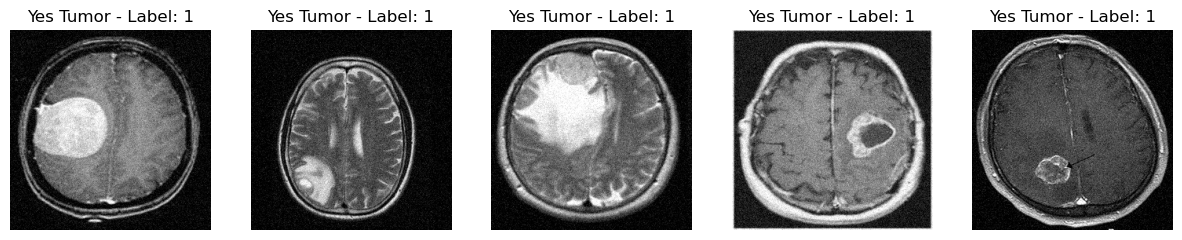

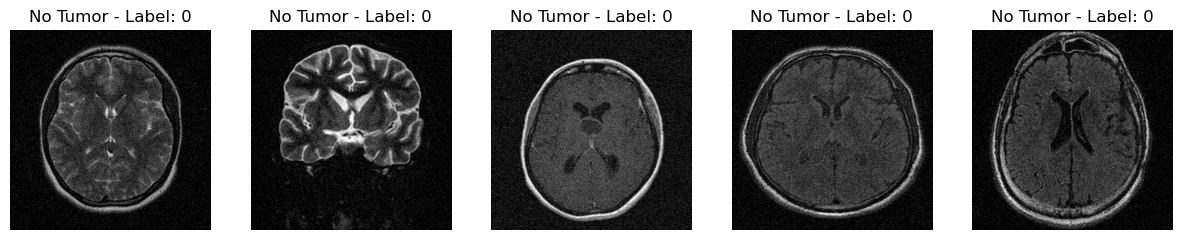

In [10]:
# Display 5 images from the 'yes' noised dataset
display_sample_images(yes_noised_data, yes_noised_labels, num_samples=5, title_prefix='Yes Tumor')

# Display 5 images from the 'no' noised dataset
display_sample_images(no_noised_data, no_noised_labels, num_samples=5, title_prefix='No Tumor')

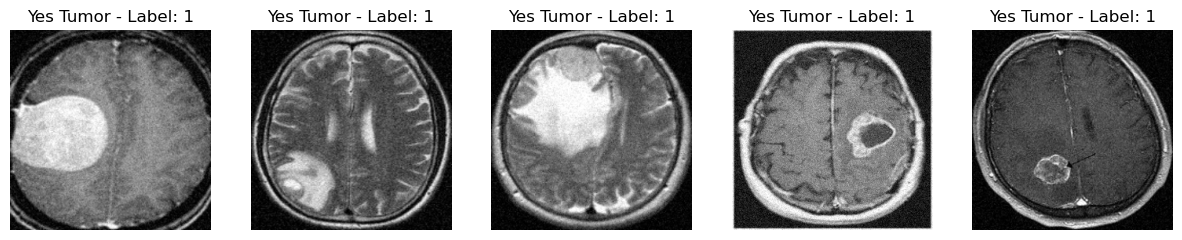

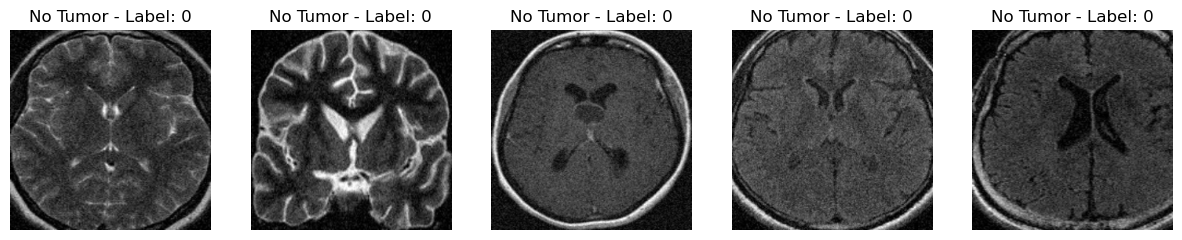

In [11]:
# Display 5 images from the 'yes' cropped dataset
display_sample_images(yes_noised_cropped_data, yes_noised_labels, num_samples=5, title_prefix='Yes Tumor')

# Display 5 images from the 'no' cropped dataset
display_sample_images(no_noised_cropped_data, no_noised_labels, num_samples=5, title_prefix='No Tumor')

In [12]:
# Combine the datasets
X = np.concatenate((yes_noised_cropped_data, no_noised_cropped_data))
y = np.concatenate((yes_noised_labels, no_noised_labels))

In [13]:
# First split: Separate 70% for training and 30% for temp (validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Second split: Divide the temp data equally into validation and test sets (50% each of 30% => 15% each)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [14]:
# Add a channel dimension to indicate grayscale
X_train = np.expand_dims(X_train, axis=-1)  # Add a new axis at the end
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# Print the shapes of the datasets to verify the new dimensions
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (217, 256, 256, 1) (217,)
Validation set shape: (46, 256, 256, 1) (46,)
Test set shape: (47, 256, 256, 1) (47,)


In [15]:
# Create image data generators for training and testing
# Normalizing and augmenting only the training data
train_datagen = ImageDataGenerator(
    rescale=1./255, # Normalize pixel values
    rotation_range=15,# Random rotations
    width_shift_range=0.05,# Random horizontal shifts
    height_shift_range=0.05,# Random vertical shifts
    shear_range=0.05,# Shear transformations
    zoom_range=0.05,# Random zoom
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,# Horizontal flipping
     vertical_flip=True,# Vertical flipping
    fill_mode='nearest' # Strategy for filling in newly created pixels
)

# Only rescale validation and test data
test_val_datagen = ImageDataGenerator(rescale=1./255)

# Prepare iterators
train_generator = train_datagen.flow(X_train, y_train, batch_size=32,shuffle=True)
val_generator = test_val_datagen.flow(X_val, y_val, batch_size=32,shuffle=False)
test_generator = test_val_datagen.flow(X_test, y_test, batch_size=32,shuffle=False)


In [16]:
# Load the ResNet50 model pre-trained on ImageNet, excluding the top fully connected layers
model_resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

class GrayToRGB(Layer):
    def __init__(self):
        super(GrayToRGB, self).__init__()

    def call(self, inputs):
        return tf.image.grayscale_to_rgb(inputs)

# Define the input shape for a grayscale image
input_shape = (256, 256, 1)  # Only one channel for grayscale

# Create the input layer that takes grayscale images
input_layer = Input(shape=input_shape)

# Use the custom GrayToRGB layer to convert grayscale to RGB
rgb_layer = GrayToRGB()(input_layer)

# Load the ResNet50 model pre-trained on ImageNet, excluding the top fully connected layers
model_resnet50 = ResNet50(weights='imagenet', include_top=False, input_tensor=rgb_layer)

# Freeze the layers of the base model
for layer in model_resnet50.layers:
    layer.trainable = False

# Add custom layers on top of ResNet50
x = GlobalAveragePooling2D()(model_resnet50.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)  # Add a dropout layer for regularization
predictions = Dense(1, activation='sigmoid')(x)  # Assuming binary classification (yes/no)

# Finalize the model
model_resnet50 = Model(inputs=input_layer, outputs=predictions)
model_resnet50.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary to verify the architecture
model_resnet50.summary()




Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 gray_to_rgb (GrayToRGB)     (None, 256, 256, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['gray_to_rgb[0][0]']         
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                           

In [17]:
history_resnet50 = model_resnet50.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator
)

Epoch 1/20


7/7 [==============================] - 21s 2s/step - loss: 0.9131 - accuracy: 0.4839 - val_loss: 0.7157 - val_accuracy: 0.5217
Epoch 2/20
7/7 [==============================] - 13s 2s/step - loss: 0.7609 - accuracy: 0.5346 - val_loss: 0.6841 - val_accuracy: 0.6304
Epoch 3/20
7/7 [==============================] - 14s 2s/step - loss: 0.6994 - accuracy: 0.5530 - val_loss: 0.6868 - val_accuracy: 0.5217
Epoch 4/20
7/7 [==============================] - 14s 2s/step - loss: 0.6619 - accuracy: 0.5760 - val_loss: 0.6833 - val_accuracy: 0.6957
Epoch 5/20
7/7 [==============================] - 13s 2s/step - loss: 0.7012 - accuracy: 0.5438 - val_loss: 0.6808 - val_accuracy: 0.5652
Epoch 6/20
7/7 [==============================] - 13s 2s/step - loss: 0.6908 - accuracy: 0.5023 - val_loss: 0.6801 - val_accuracy: 0.6304
Epoch 7/20
7/7 [==============================] - 14s 2s/step - loss: 0.6704 - accuracy: 0.5622 - val_loss: 0.6893 - val_accuracy: 0.5217
Epoch 8/20
7/7 [================

2/2 [==============================] - 5s 2s/step - loss: 0.6886 - accuracy: 0.5532
Test Loss: 0.688584566116333
Test Accuracy: 0.5531914830207825
2/2 [==============================] - 10s 1s/step


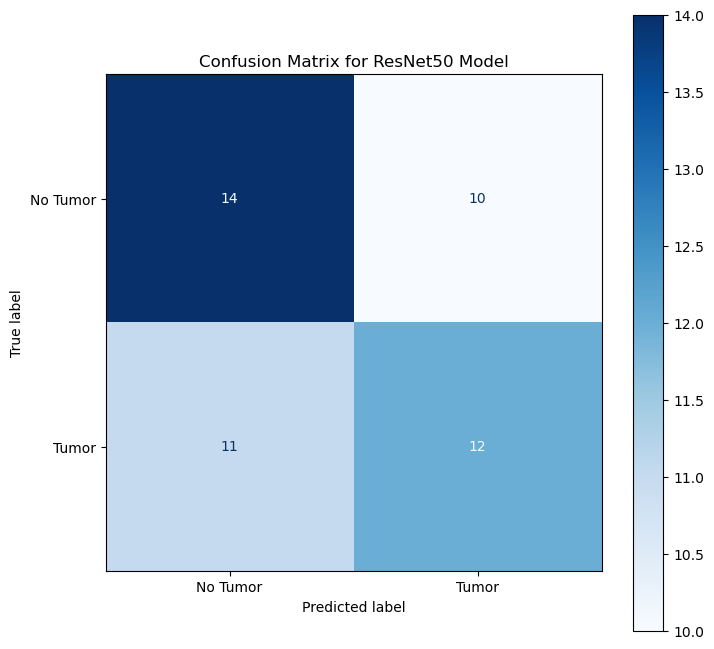

Classification Report for ResNet50 Model:
               precision    recall  f1-score   support

    No Tumor       0.56      0.58      0.57        24
       Tumor       0.55      0.52      0.53        23

    accuracy                           0.55        47
   macro avg       0.55      0.55      0.55        47
weighted avg       0.55      0.55      0.55        47



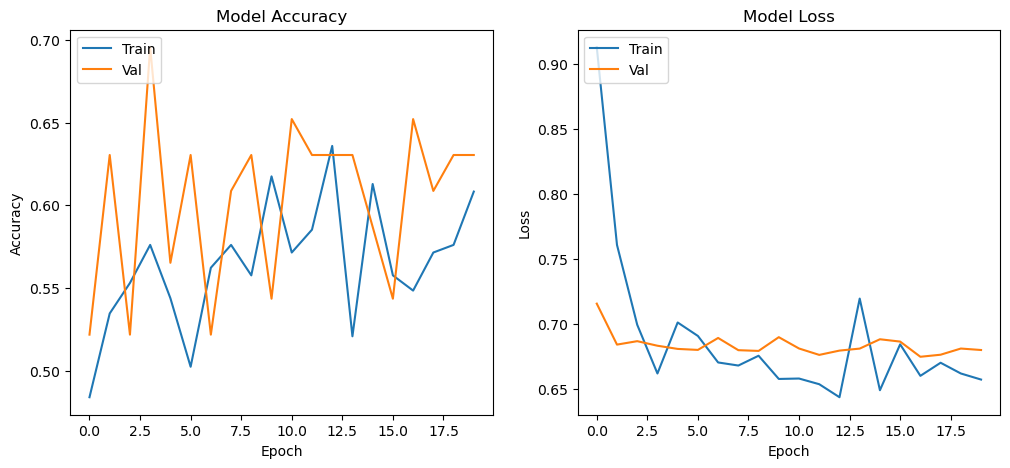

In [18]:
# Evaluate the model on the test data
test_metrics_resnet50 = model_resnet50.evaluate(test_generator)
print('Test Loss:', test_metrics_resnet50[0])
print('Test Accuracy:', test_metrics_resnet50[1])

# Generate predictions
true_classes_resnet50 = y_test
predictions_resnet50 = model_resnet50.predict(test_generator)
predicted_classes_resnet50 = (predictions_resnet50 > 0.5).astype(int).flatten()

# Compute the confusion matrix
conf_matrix_resnet50 = confusion_matrix(true_classes_resnet50, predicted_classes_resnet50)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(conf_matrix_resnet50, display_labels=['No Tumor', 'Tumor'])
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix for ResNet50 Model')
plt.show()

# Generate the classification report
report_resnet50 = classification_report(true_classes_resnet50, predicted_classes_resnet50, target_names=['No Tumor', 'Tumor'])
print("Classification Report for ResNet50 Model:\n", report_resnet50)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_resnet50.history['accuracy'])
plt.plot(history_resnet50.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_resnet50.history['loss'])
plt.plot(history_resnet50.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.show()


In [22]:
def create_cnn_model():
    model = Sequential([
        Conv2D(16, (3, 3), activation='relu', input_shape=(256, 256, 1)),  # Assuming input shape is 256x256 with 3 channels
        MaxPooling2D(2, 2),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')  # Use 'softmax' and change units if you have more than two classes
    ])
    
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',  # Use 'categorical_crossentropy' for multi-class
                  metrics=['accuracy'])
    
    return model

# Create the simple model
cnn_model = create_cnn_model()
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_94 (Conv2D)          (None, 254, 254, 16)      160       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_95 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 123008)            0         
                                                                 
 dense_5 (Dense)             (None, 64)                7

In [23]:
# Assuming you already have a data generator setup
cnn_history = cnn_model.fit(
    train_generator,
    epochs=20,  
    validation_data=val_generator,
)


Epoch 1/20
7/7 [==============================] - 4s 401ms/step - loss: 4.3938 - accuracy: 0.4931 - val_loss: 0.6886 - val_accuracy: 0.6087
Epoch 2/20
7/7 [==============================] - 7s 1s/step - loss: 0.7511 - accuracy: 0.5207 - val_loss: 0.7979 - val_accuracy: 0.5000
Epoch 3/20
7/7 [==============================] - 10s 1s/step - loss: 0.6902 - accuracy: 0.5392 - val_loss: 0.7037 - val_accuracy: 0.5000
Epoch 4/20
7/7 [==============================] - 9s 1s/step - loss: 0.6905 - accuracy: 0.5346 - val_loss: 0.6472 - val_accuracy: 0.6739
Epoch 5/20
7/7 [==============================] - 3s 338ms/step - loss: 0.6703 - accuracy: 0.6083 - val_loss: 0.6703 - val_accuracy: 0.5870
Epoch 6/20
7/7 [==============================] - 2s 339ms/step - loss: 0.6483 - accuracy: 0.6452 - val_loss: 0.6361 - val_accuracy: 0.6304
Epoch 7/20
7/7 [==============================] - 5s 832ms/step - loss: 0.6201 - accuracy: 0.6636 - val_loss: 0.6813 - val_accuracy: 0.5870
Epoch 8/20
7/7 [============

2/2 [==============================] - 0s 31ms/step - loss: 0.7863 - accuracy: 0.5957
Test Loss: 0.7863243818283081
Test Accuracy: 0.5957446694374084
2/2 [==============================] - 0s 30ms/step


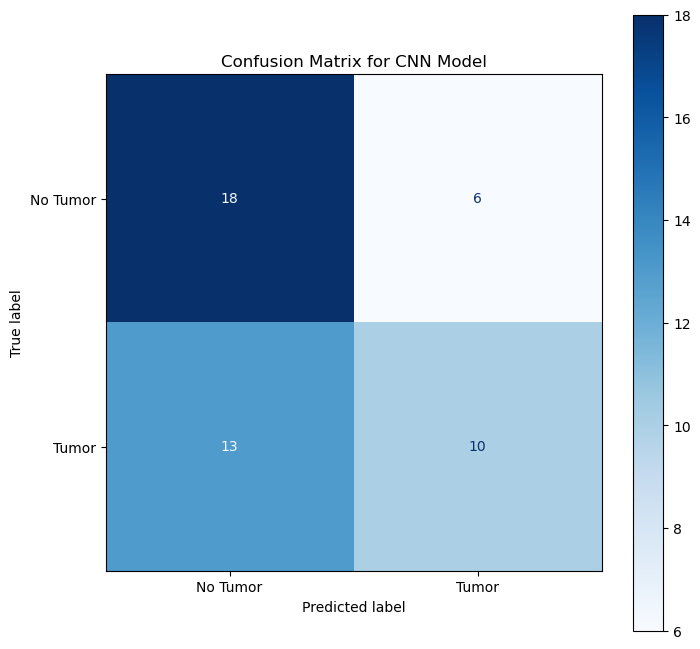

Classification Report for CNN Model:
               precision    recall  f1-score   support

    No Tumor       0.58      0.75      0.65        24
       Tumor       0.62      0.43      0.51        23

    accuracy                           0.60        47
   macro avg       0.60      0.59      0.58        47
weighted avg       0.60      0.60      0.59        47



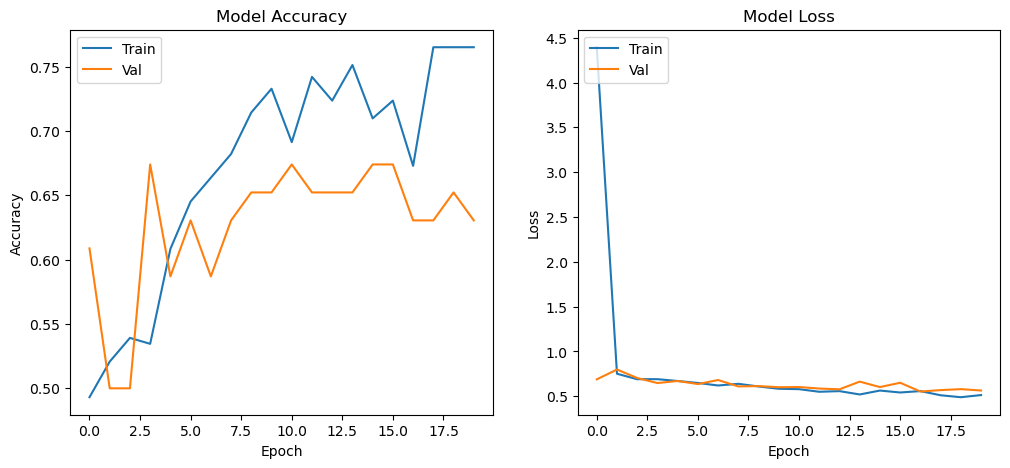

In [24]:
# Evaluate the model on the test data
test_metrics_cnn = cnn_model.evaluate(test_generator)
print('Test Loss:', test_metrics_cnn[0])
print('Test Accuracy:', test_metrics_cnn[1])

# Generate predictions
true_classes_cnn = y_test
predictions_cnn= cnn_model.predict(test_generator)
predicted_classes_cnn = (predictions_cnn> 0.5).astype(int).flatten()

# Compute the confusion matrix
conf_matrix_cnn= confusion_matrix(true_classes_cnn, predicted_classes_cnn)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(conf_matrix_cnn, display_labels=['No Tumor', 'Tumor'])
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix for CNN Model')
plt.show()

# Generate the classification report
report_cnn = classification_report(true_classes_cnn, predicted_classes_cnn, target_names=['No Tumor', 'Tumor'])
print("Classification Report for CNN Model:\n", report_cnn)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.show()
